## 1 - Import

In [158]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, norm
import scipy.stats as stats

drive.mount('/content/drive')
path_drive = '/content/drive/My Drive/Projet_12/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2 - Chargement et exploration des données

In [159]:
# Chargement du fichier csv fourni
df = pd.read_csv(path_drive + 'billets.csv', delimiter=";")

In [160]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [162]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [163]:
# Vérifier les valeurs manquantes
df.isnull().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,37
margin_up,0
length,0


In [164]:
df['is_genuine'].value_counts()

,count
is_genuine,
True,1000
False,500


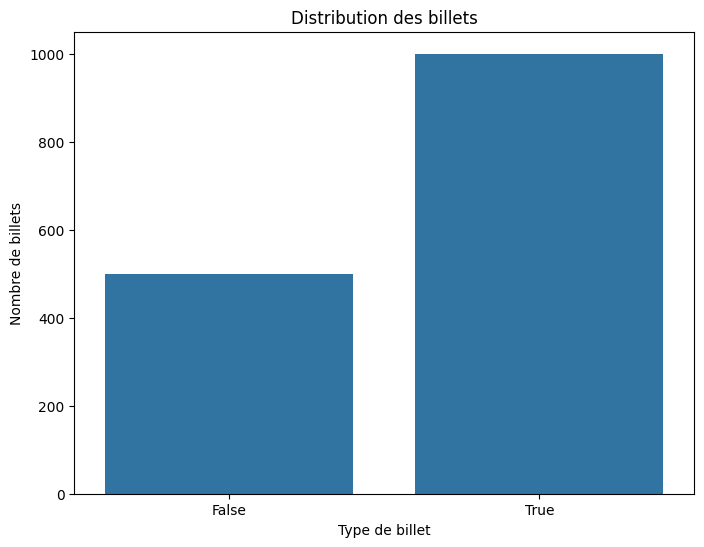

In [165]:
# Visualisation de la distribution des billets
plt.figure(figsize=(8, 6))
sns.countplot(x='is_genuine', data=df)
plt.title('Distribution des billets')
plt.xlabel('Type de billet')
plt.ylabel('Nombre de billets')
plt.show()

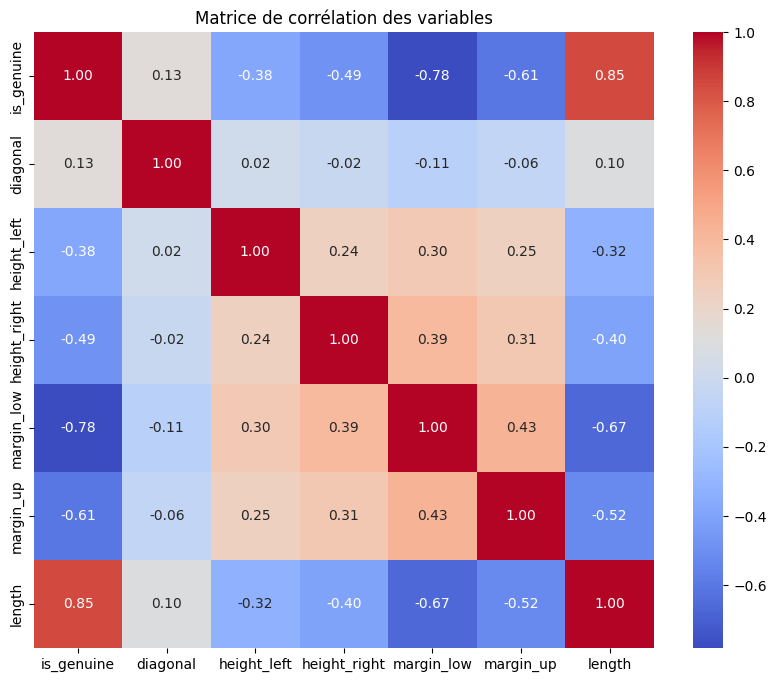

In [166]:
# Analyse des corrélations
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables')
plt.show()

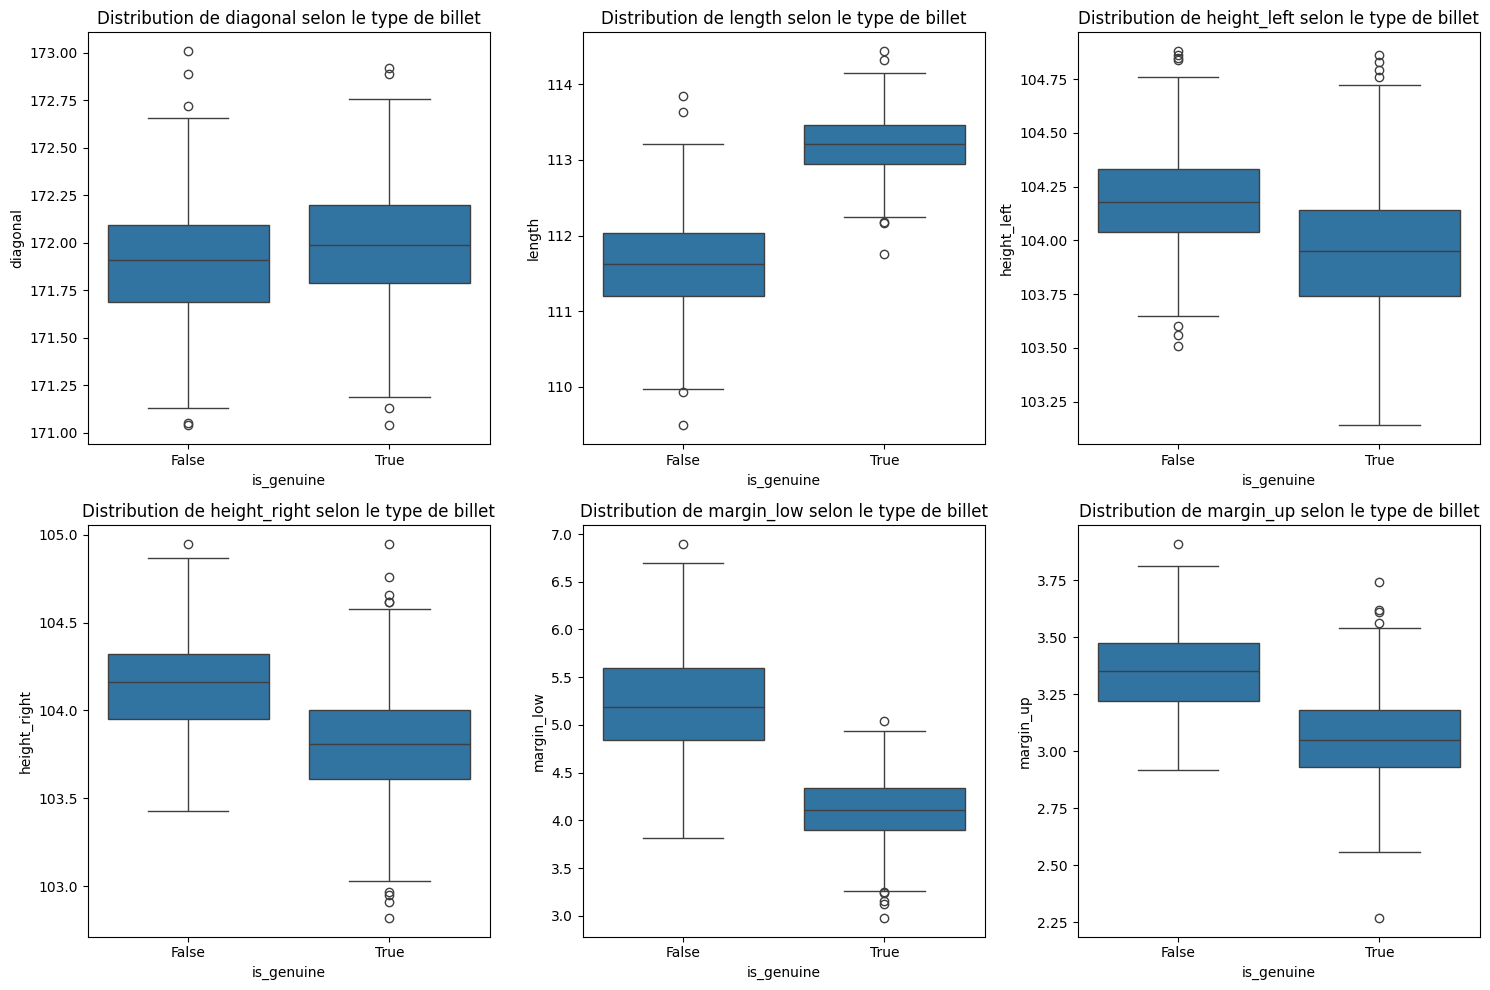

In [167]:
# Visualisation des distributions de chaque variable selon le type de billet
features = ['diagonal',  'length', 'height_left', 'height_right', 'margin_low', 'margin_up']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='is_genuine', y=feature, data=df)
    plt.title(f'Distribution de {feature} selon le type de billet')
plt.tight_layout()
plt.show()

- length est la variable la plus discriminante : les vrais billets sont globalement plus longs.
- margin_low et margin_up présentent aussi des différences claires : les faux billets ont en moyenne une marge plus large.
- diagonal, height_left et height_right montrent peu de différences nettes entre les classes.


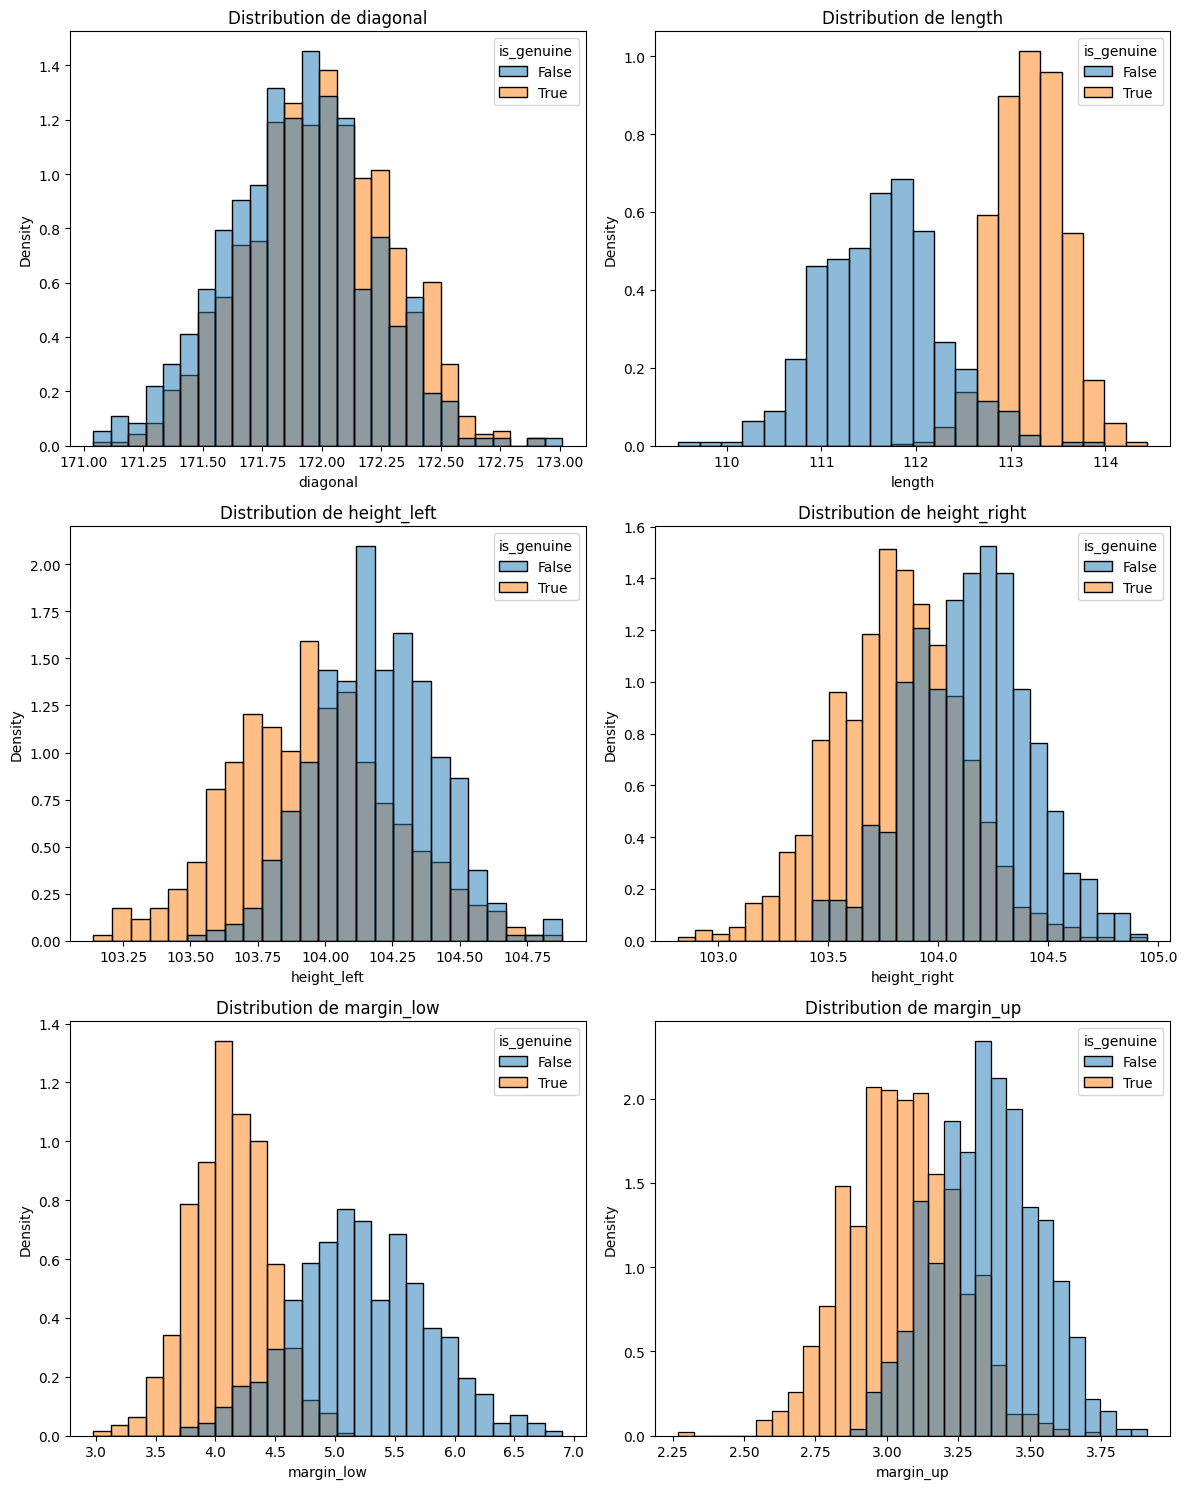

In [168]:
# Histogramme de distribution
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

index = 0
for x in range(3):
    for y in range(2):
        column = features[index]
        sns.histplot(data=df, x=column, hue="is_genuine", stat="density", ax=ax[x][y], common_norm=False)
        ax[x][y].set_title(f"Distribution de {column}")
        index += 1

plt.tight_layout()
plt.show()

- La variable length ressort une fois de plus comme très discriminante.
- margin_low montre aussi une distribution décalée.
- Les autres variables ont des distributions très proches entre vrais et faux billets.

<Figure size 640x480 with 0 Axes>

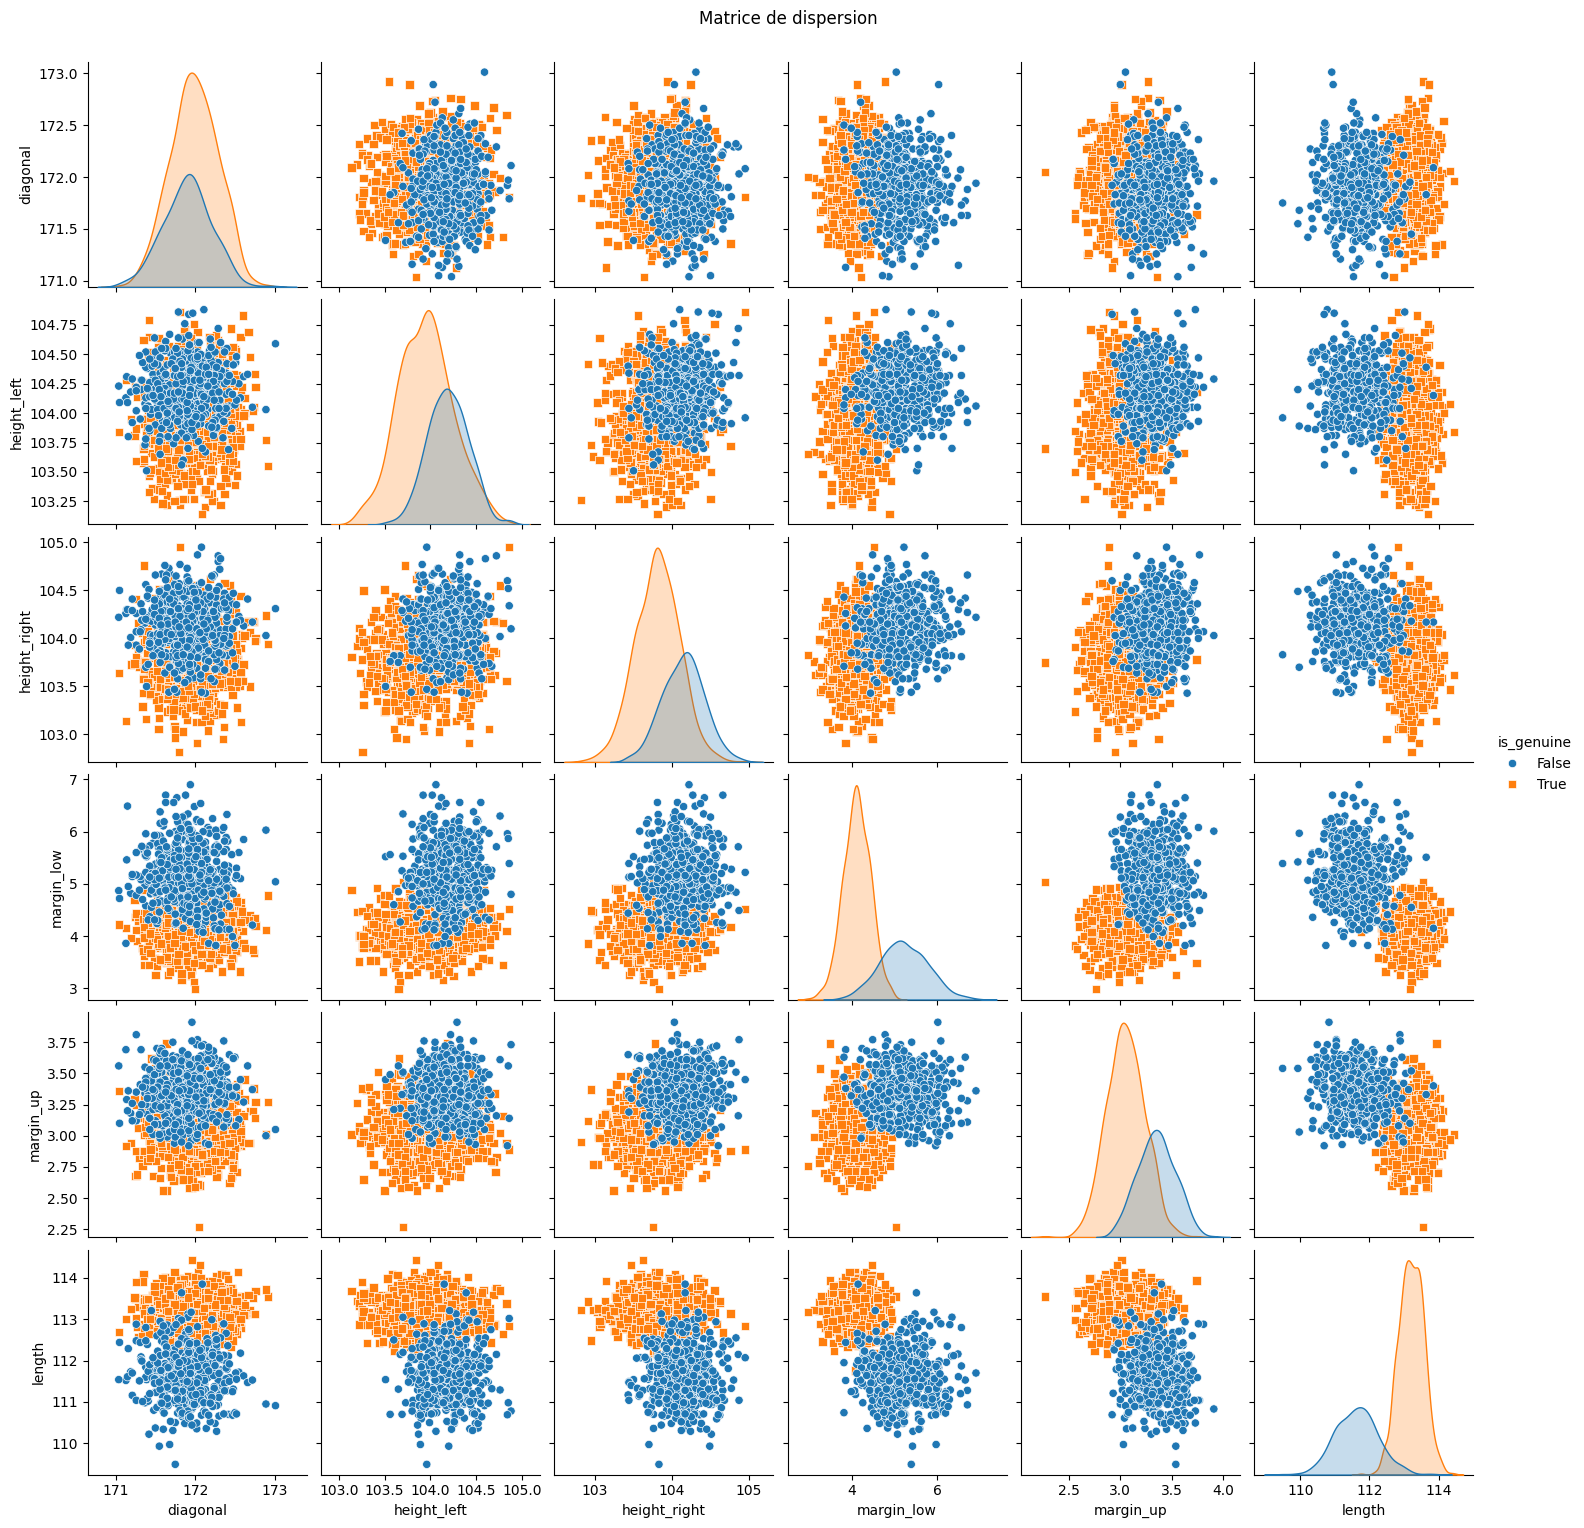

In [169]:
plt.figure()
sns.pairplot(df, hue="is_genuine", markers=['o','s'])
plt.suptitle("Matrice de dispersion", y=1.02)
plt.show()

## 3. Traitement des valeurs manquantes

In [170]:
# Séparation des données avec et sans valeurs manquantes pour 'margin_low'
data_missing = df[df['margin_low'].isnull()]
data_no_missing = df.dropna()

In [171]:
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
X = data_no_missing[features]
y = data_no_missing['margin_low']

In [172]:
# Régression linéaire pour estimer les valeurs manquantes
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [173]:
# Prédiction des valeurs manquantes
predicted_values = model.predict(X)
predicted_values_missing = model.predict(data_missing[features])

In [174]:
r2 = model.score(data_no_missing[features], data_no_missing['margin_low'])
print("R² :", r2)

R² : 0.4773366973063957


In [175]:
# Création d'un modèle avec statsmodels pour obtenir plus de détails
reg_multi = smf.ols('margin_low~+diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 23 May 2025   Prob (F-statistic):          2.60e-202
Time:                        15:52:47   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

In [176]:
residuals = data_no_missing['margin_low'] - predicted_values

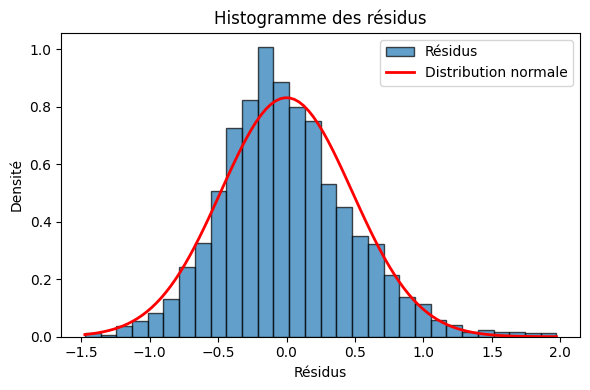

In [177]:
# Créer un histogramme des résidus
plt.figure(figsize=(6, 4))
count, bins, ignored = plt.hist(residuals, bins=30, density=True, edgecolor='black', alpha=0.7, label="Résidus")

# Tracer la courbe de la distribution normale
mean = residuals.mean()
std = residuals.std()
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, norm.pdf(x, mean, std), 'r-', linewidth=2, label="Distribution normale")

plt.title("Histogramme des résidus")
plt.xlabel("Résidus")
plt.ylabel("Densité")
plt.legend()
plt.tight_layout()
plt.show()

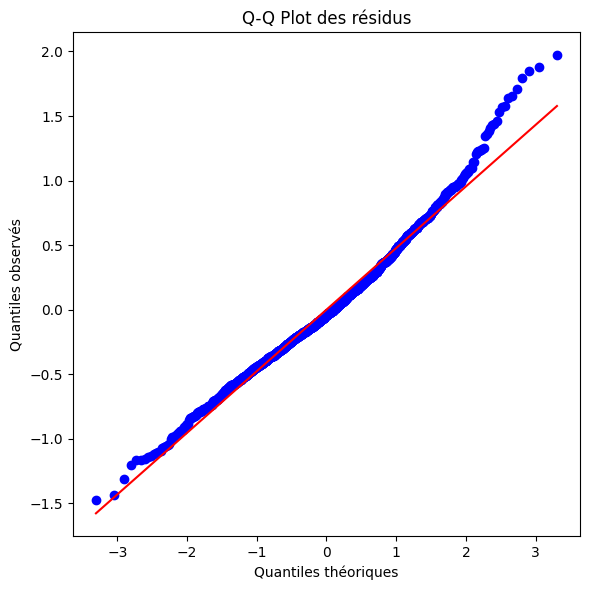

In [178]:
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot des résidus")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés")
plt.tight_layout()
plt.show()

In [179]:
# Test de Shapiro-Wilk sur les résidus
stat, p_value = shapiro(residuals)
# Afficher le résultat
print("Statistique de test :", stat)
print("p-value :", p_value)
if p_value > 0.05:
    print("Les résidus suivent une distribution normale.")
else:
    print("Les résidus ne suivent pas une distribution normale.")

Statistique de test : 0.9857882577573777
p-value : 8.54040784238793e-11
Les résidus ne suivent pas une distribution normale.


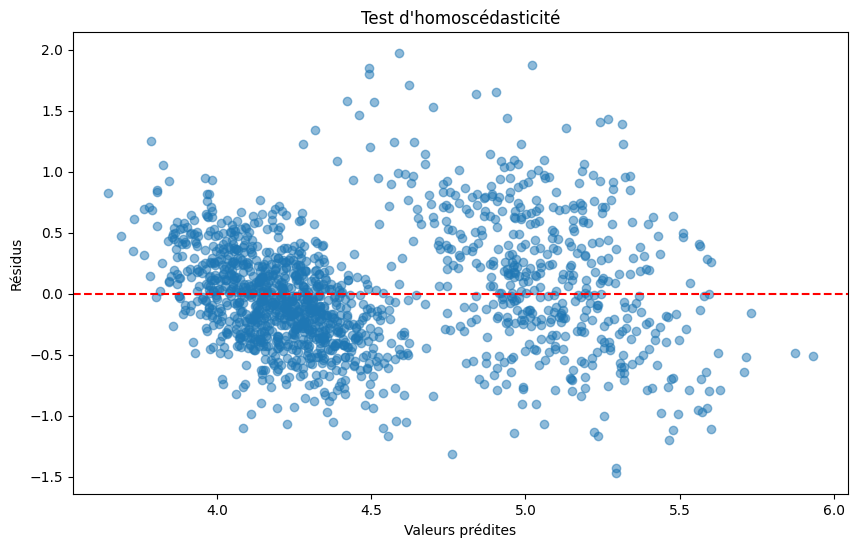

In [180]:
plt.figure(figsize=(10,6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Test d'homoscédasticité")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

In [181]:
# Sélection des variables explicatives (sans margin_low et is_genuine si tu veux éviter les biais)
X = df[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']].dropna()

# Ajout d'une constante
X_const = add_constant(X)

# Calcul du VIF
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif


,Variable,VIF
0,const,591443.076346
1,diagonal,1.012790
2,height_left,1.145295
3,height_right,1.229263
4,margin_up,1.403517
5,length,1.574765


Malgré le non-respect des trois conditions de validité (normalité des résidus, colinéarité acceptable, homoscédasticité) et un R² faible, j’ai choisi d’utiliser la régression linéaire pour imputer les valeurs manquantes de manière temporaire

In [182]:
# Remplir les valeurs manquantes
df_filled = df.copy()
df_filled.loc[df_filled['margin_low'].isnull(), 'margin_low'] = predicted_values_missing

In [183]:
df_filled.isnull().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,0
margin_up,0
length,0


In [184]:
df_copy = df_filled.copy()
df_copy.drop('is_genuine', axis=1, inplace=True)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_copy)
df_scaled = pd.DataFrame(data_scaled, columns=df_copy.columns)

## K-Means

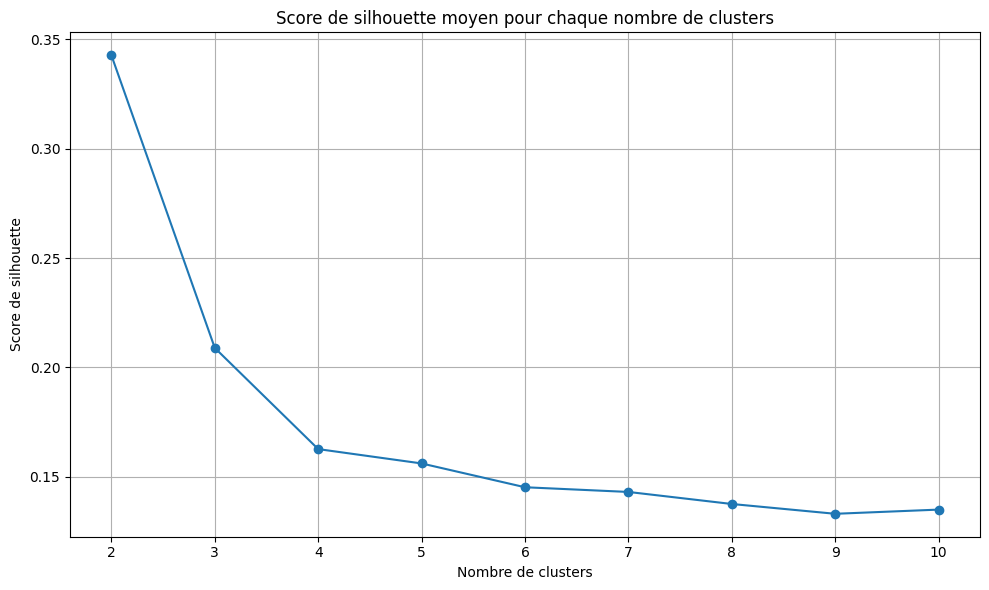

In [185]:
# Calcul des scores de silhouette pour différents nombres de clusters
max_clusters = 10
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title("Score de silhouette moyen pour chaque nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.grid(True)
plt.tight_layout()
plt.show()

In [186]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df_scaled)
centroids = kmeans.cluster_centers_

In [187]:
df_clusters = df_filled.copy()
df_clusters['cluster'] = clusters

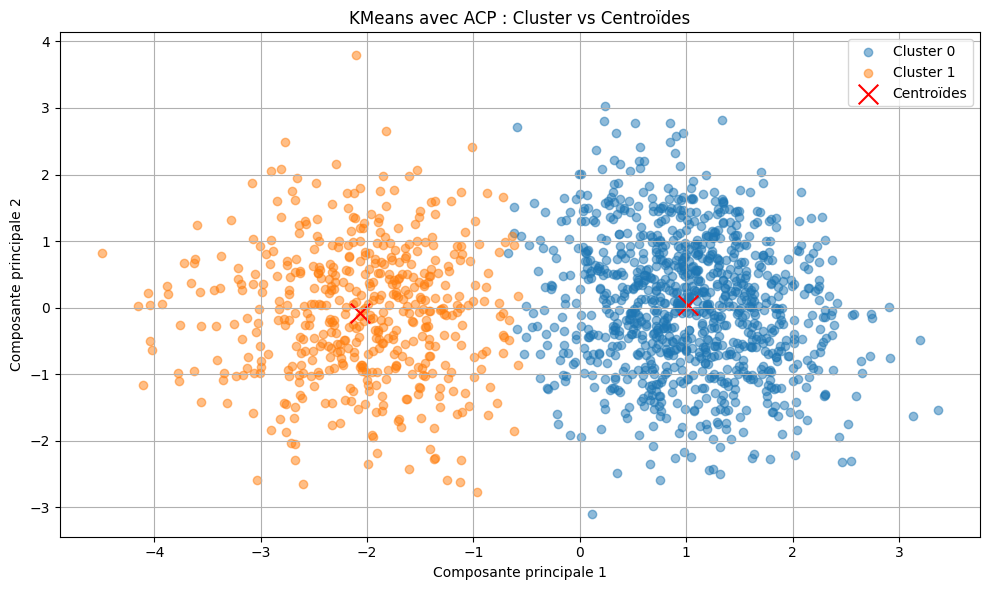

In [188]:
# Application de l'ACP pour réduire à 2 dimensions
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Transformation des centroïdes dans l'espace PCA
centroids_pca = pca.transform(centroids)

# Visualisation des clusters dans l'espace PCA
labels = [f"Cluster {i}" for i in range(2)]

# Visualisation avec légende personnalisée
plt.figure(figsize=(10, 6))

# Afficher les points des billets par cluster
for i in range(2):
    plt.scatter(data_pca[clusters == i, 0],
                data_pca[clusters == i, 1],
                label=f'Cluster {i}',
                alpha=0.5)

# Afficher les centroïdes
plt.scatter(centroids_pca[:, 0],
            centroids_pca[:, 1],
            c='red',
            marker='x',
            s=200,
            label='Centroïdes')
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("KMeans avec ACP : Cluster vs Centroïdes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

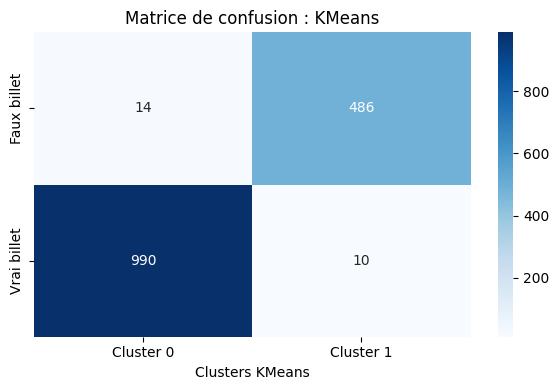

In [189]:
conf_matrix = confusion_matrix(df_clusters['is_genuine'], df_clusters['cluster'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Faux billet', 'Vrai billet'])
plt.xlabel("Clusters KMeans")
plt.title("Matrice de confusion : KMeans")
plt.tight_layout()
plt.show()

In [190]:
# Récupère les vraies classes
true_labels = df_clusters['is_genuine'].values
# Récupère les clusters prédits par KMeans
cluster_labels = df_clusters['cluster'].values

accuracy_1 = accuracy_score(true_labels, cluster_labels)
accuracy_2 = accuracy_score(true_labels, 1 - cluster_labels)

# Meilleure accuracy
best_accuracy = max(accuracy_1, accuracy_2)
print("Meilleure accuracy obtenue :", best_accuracy)

Meilleure accuracy obtenue : 0.984


98,4%

## Algorithmes supervisés

Préparer les données train/test

In [191]:
X = df_scaled
y = df_filled['is_genuine']

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

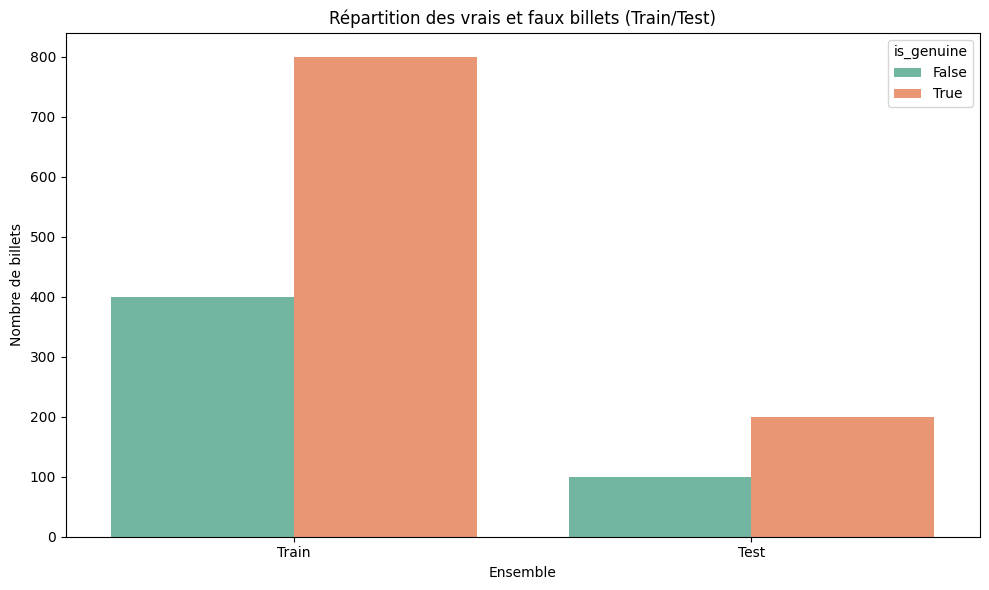

In [193]:

# Création d'un DataFrame pour l'affichage
split_data = pd.DataFrame({
    "is_genuine": y_train.tolist() + y_test.tolist(),
    "set": ["Train"] * len(y_train) + ["Test"] * len(y_test)
})

# Création de l'histogramme
plt.figure(figsize=(10, 6))
sns.countplot(data=split_data, x="set", hue="is_genuine", palette="Set2")
plt.title("Répartition des vrais et faux billets (Train/Test)")
plt.xlabel("Ensemble")
plt.ylabel("Nombre de billets")
plt.legend(title="is_genuine", labels=["False", "True"])
plt.tight_layout()
plt.show()


In [194]:
def matrice_confusion(y_test, y_pred, algo_name):
  # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Affichage graphique
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Faux billet (0)', 'Vrai billet (1)'],
                yticklabels=['Faux billet (0)', 'Vrai billet (1)'])
    plt.xlabel("Prédictions")
    plt.ylabel("Valeurs réelles")
    plt.title(f"Matrice de confusion - {algo_name}")
    plt.tight_layout()
    plt.show()
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

### Régression logistique

In [195]:
regression = LogisticRegression()
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

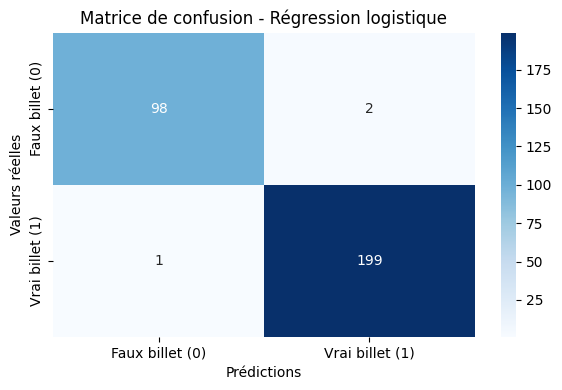

              precision  recall  f1-score  support
False          0.989899  0.9800  0.984925   100.00
True           0.990050  0.9950  0.992519   200.00
accuracy       0.990000  0.9900  0.990000     0.99
macro avg      0.989974  0.9875  0.988722   300.00
weighted avg   0.989999  0.9900  0.989987   300.00


In [196]:
matrice_confusion(y_test, y_pred, algo_name="Régression logistique")

In [197]:
# Récupération des coefficients du modèle
coefficients = regression.coef_[0]
features = X.columns
coef_df = pd.DataFrame({'Variable': features, 'Coefficient': coefficients})
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])  # Calcul des odds ratio
coef_df

,Variable,Coefficient,Odds Ratio
0,diagonal,0.185852,1.204244
1,height_left,-0.353382,0.702309
2,height_right,-0.648472,0.522844
3,margin_low,-2.638736,0.071452
4,margin_up,-1.634791,0.194993
5,length,3.688349,39.978782


### KNN

Meilleur k trouvé : 12 avec un score de 0.9925


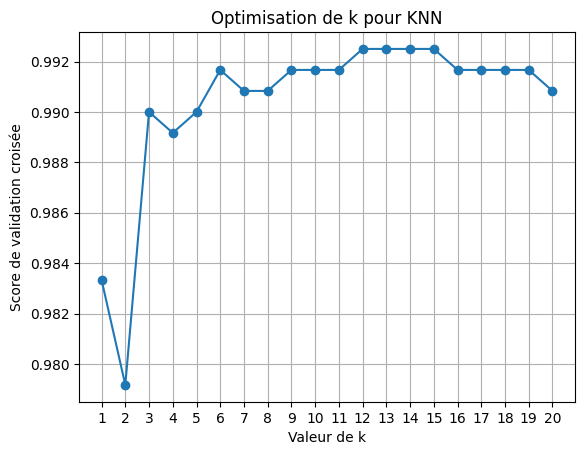

In [198]:
k_range = range(1, 21)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

best_k = k_range[np.argmax(cv_scores)]
print(f"Meilleur k trouvé : {best_k} avec un score de {max(cv_scores):.4f}")

plt.plot(k_range, cv_scores, marker='o')
plt.xticks(k_range)
plt.xlabel('Valeur de k')
plt.ylabel('Score de validation croisée')
plt.title('Optimisation de k pour KNN')
plt.grid(True)
plt.show()

In [199]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn.predict(X_test)

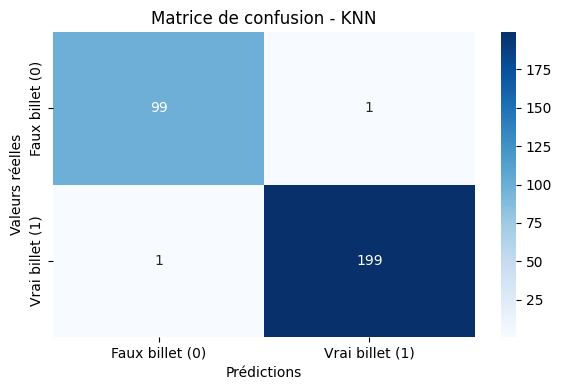

              precision    recall  f1-score     support
False          0.990000  0.990000  0.990000  100.000000
True           0.995000  0.995000  0.995000  200.000000
accuracy       0.993333  0.993333  0.993333    0.993333
macro avg      0.992500  0.992500  0.992500  300.000000
weighted avg   0.993333  0.993333  0.993333  300.000000


In [200]:
matrice_confusion(y_test, y_pred_knn, algo_name="KNN")

### Random Forest

Meilleur n_estimators : 240 avec un score de 0.9917


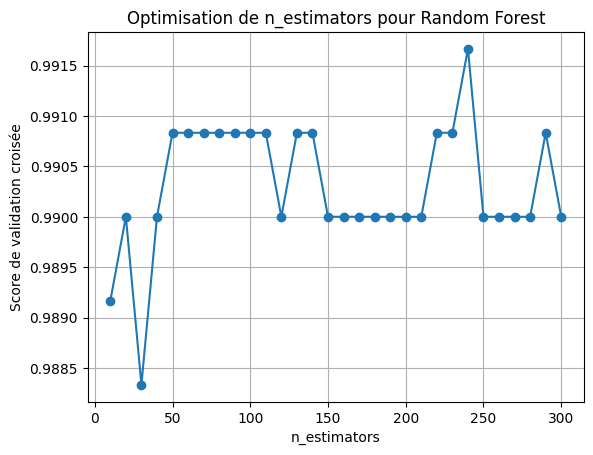

In [201]:
# Test de différentes tailles de forêts
n_estimators_range = range(10, 310, 10)
cv_scores = []

for n in n_estimators_range:
  rf = RandomForestClassifier(n_estimators=n, random_state=42)
  scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
  cv_scores.append(scores.mean())

# Meilleur n_estimators
best_n = n_estimators_range[np.argmax(cv_scores)]
print(f"Meilleur n_estimators : {best_n} avec un score de {max(cv_scores):.4f}")

plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Score de validation croisée')
plt.title('Optimisation de n_estimators pour Random Forest')
plt.grid(True)
plt.show()

In [202]:
# Random Forest
rf = RandomForestClassifier(n_estimators=best_n, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

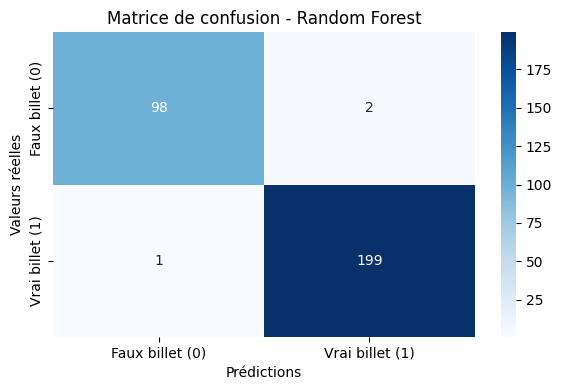

              precision  recall  f1-score  support
False          0.989899  0.9800  0.984925   100.00
True           0.990050  0.9950  0.992519   200.00
accuracy       0.990000  0.9900  0.990000     0.99
macro avg      0.989974  0.9875  0.988722   300.00
weighted avg   0.989999  0.9900  0.989987   300.00


In [203]:
matrice_confusion(y_test, y_pred_rf, algo_name="Random Forest")

Après avoir comparé 4 modèles, j’ai choisi la régression logistique comme modèle final.
Elle atteint une performance quasi équivalente aux autres, tout en étant beaucoup plus simple à mettre en place.

In [204]:
import joblib

# Création des mes 2 fichiers pickle avec mes 2 méthodes
joblib.dump(regression, path_drive + 'model_logistic.pkl')
joblib.dump(scaler, path_drive + 'scaler.pkl')

['/content/drive/My Drive/Projet_12/data/scaler.pkl']